In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
%matplotlib inline
import VersionZeroPointZero as PSS
from scipy import signal

ImportError: No module named 'VersionZeroPointZero'

I incorporated your changes, but there were a few typos that I fixed. Some of the pulsar_object and signal_object calls were mixed up, and the syntax for creating the dictionary was incorrect I think.

In [ ]:
def DMBroaden(pulsar_object, signal_object):
    """
    This is a function that convolves a pulsar profile with a top hat function
    to simulate the process of dispersion broadening.
       
    Parameters
    ---------
    pulsar_object: VersionZeroPointZero.pulsar.Pulsar object
        The pulsar object 
    signal_object: VersionZeroPointZero.signal.Signal
        The signal object
    
    Notes
    -----
    Also records the DM widths in the MetaData of the signal object.
    """
    dm_widths = np.zeros(pulsar_object.Nf)
    for ii, freq in enumerate(pulsar_object.Signal_in.freq_Array):
        sub_band_width = pulsar_object.bw/pulsar_object.Nf
        width = int(PSS.utils.top_hat_width(sub_band_width, freq, 100)//pulsar_object.TimeBinSize)
        if width > pulsar_object.Nt:
            raise ValueError('Too Much DM! Dispersion broadening top hat wider than data array!')
        dm_widths[ii] = width
        pulsar_object.profile[ii,:] = sp.convolve(pulsar_object.profile[ii,:], signal.boxcar(width)/width,'same')
    Dict = {'dm_widths':dm_widths}
    signal_object.MetaData.AddInfo(Dict)

In [3]:
S1=PSS.Signal(Nt=2000)
P1=PSS.Pulsar(S1)
I1=PSS.ism.ISM(S1)
PSS.ism.ISM.finalize_ism(I1)

NameError: name 'PSS' is not defined

In [5]:
peak3 = np.random.randn(20*3)*0.01 + 0.2
width3 = abs(np.random.randn(20*3)*0.002 +0.012)
amp3 = np.random.randn(20*3)**2
peak3.resize(20,3)
width3.resize(20,3)
amp3.resize(20,3)
P1.gauss_template(peak=peak3,width=width3,amp=amp3)

In [6]:
DMBroaden(P1,S1)

In [7]:
P1.make_pulses()

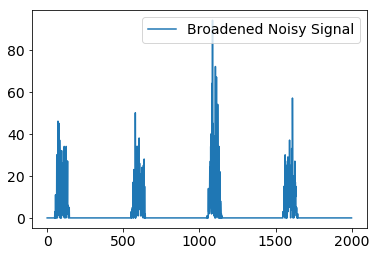

In [8]:
plt.plot(P1.signal[5],label="Broadened Noisy Signal")
plt.legend()
plt.show()

In [9]:
# I'll put this little gem into the simulator when I have a chance... 
def ProfilePlot(array, step=1, N=10,Title='Profile by Frequency Channel'):
    try:
        array_len = len(N)
        jj = 0
        for ii, jj in enumerate(N):
            plot(array[jj,:]+ii*(step),c='k')
        n=len(N)
    except:
        Freq_channels = len(array[:,0])
        Freq_step = int(Freq_channels//N)
        for ii in range(N):
            plot(array[ii*Freq_step,:]+ii*(step),c='k')
        n=N
    title(Title)
    xlabel('Phase')
    ylabel('Frequency Channel')
    xticks([])
    yticks([])
    xlim(0,len(array[0,:]))
    ylim(0,n*step+0.1)
    show()

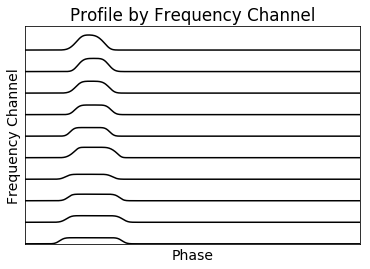

In [10]:
ProfilePlot(P1.profile)

# Working on convolving with an exponential

In [11]:
del S1, P1, I1

In [12]:
S2=PSS.Signal(Nt=2000,mode='simulate')
P2=PSS.Pulsar(S2)
I2=PSS.ISM(S2,mode='simulate')
I2.finalize_ism() 

In [13]:
def Scatter(pulsar_object, signal_object,tau_d_in=1):
    """
    width = pulsar_object.nBinsPeriod
    tau_scatter_time = PSS.scintillation.scale_tau_d(tau_d = tau_d_in,nu_i = signal_object.f0,nu_f = signal_object.freq_Array)
    tau_scatter_bins = tau_scatter_time / signal_object.TimeBinSize
    #Iterating over the tau arrays where each profile 
    #corresponds to the respective tau index
    for ii, tau_bin in enumerate(tau_scatter_bins): 
        t = np.linspace(0,width)
        EXP = (np.exp(-t/tau_bin))
        EXP_sum = np.sum(EXP)
        EXP_norm = EXP / EXP_sum
        pulsar_prof_sum = np.sum(pulsar_object.profile[ii,:])
        pulsar_prof_norm = pulsar_object.profile[ii,:] / pulsar_prof_sum
        convolved_prof = sp.convolve(pulsar_prof_norm, EXP_norm,"full")
        #Need to cut the convolved function off at the length of the inital pulsar profile
        pulsar_object.profile[ii,:] = (pulsar_prof_sum)*(convolved_prof[:width])

In [14]:
def Scintillation2(pulsar_object, signal_object,tau_d_in=10):
    """DRAFT DOCSTRING:
    This is a function that convolves a pulsar profile with an exponential function
    to simulate the process of scattering.
       
    Parameters
    ---------
    pulsar_object: VersionZeroPointZero.pulsar.Pulsar object
        The pulsar object 
    signal_object: VersionZeroPointZero.signal.Signal
        The signal object
    tau_d_in: VersionZeroPointZero.scintillation.scale_tau_d
        The scattering time
        In units of milliseconds, default 1ms
        See Cordes et al. 1990
    """
    width = pulsar_object.nBinsPeriod
    tau_scatter_time = PSS.scintillation.scale_tau_d(tau_d = tau_d_in,nu_i = signal_object.f0,nu_f = signal_object.freq_Array)
    tau_scatter_bins = tau_scatter_time / signal_object.TimeBinSize
    t = np.linspace(0,pulsar_object.T,width)
    #Iterating over the tau arrays where each profile 
    #corresponds to the respective tau index
    for ii, tau_scatter in enumerate(tau_scatter_time): 
        EXP = (np.exp(-t/tau_scatter))
        EXP_sum = np.sum(EXP)
        EXP_norm = EXP / EXP_sum
        pulsar_prof_sum = np.sum(pulsar_object.profile[ii,:])
        pulsar_prof_norm = pulsar_object.profile[ii,:] / pulsar_prof_sum
        convolved_prof = sp.convolve(pulsar_prof_norm, EXP_norm,"full")
        #Need to cut the convolved function off at the length of the inital pulsar profile
        pulsar_object.profile[ii,:] = (pulsar_prof_sum)*(convolved_prof[:width])

In [14]:
P2.make_pulses()

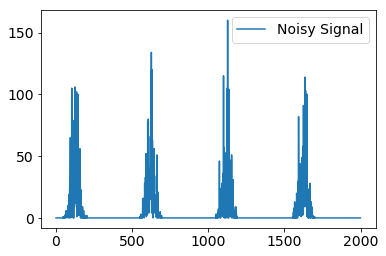

In [16]:
plt.plot(P2.signal[5],label="Noisy Signal")
plt.legend()
plt.show()

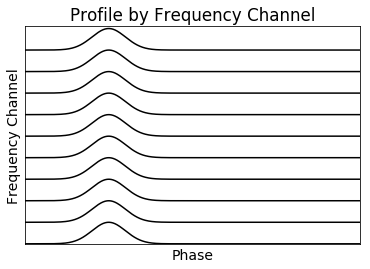

In [17]:
ProfilePlot(P2.profile)

In [18]:
DMBroaden(P2,S2)
Scatter(P2,S2,2)

In [18]:
P2.make_pulses()

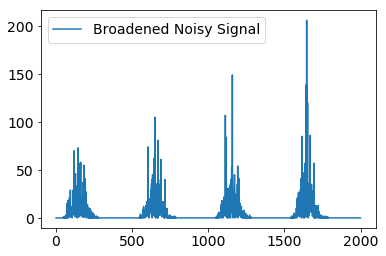

In [19]:
plt.plot(P2.signal[5],label="Broadened Noisy Signal")
plt.legend()
plt.show()

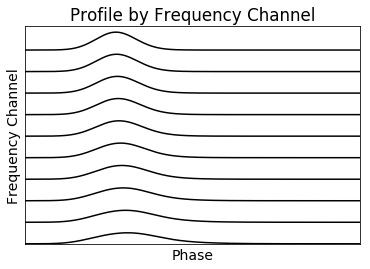

In [21]:
ProfilePlot(P2.profile)

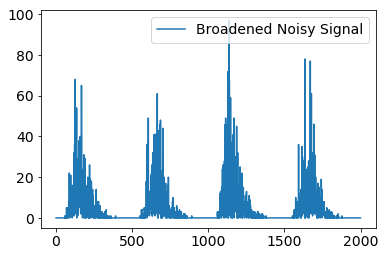

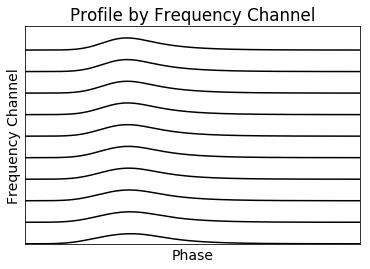

In [22]:
S3=PSS.Signal(Nt=2000,mode='simulate')
P3=PSS.Pulsar(S3)
I3=PSS.ISM(S3,mode='simulate')
I3.finalize_ism() 
DMBroaden(P3,S3)
Scintillation2(P3,S3,10,10)
P3.make_pulses()
plt.plot(P3.signal[5],label="Broadened Noisy Signal")
plt.legend()
plt.show()
ProfilePlot(P3.profile)